<a href="https://colab.research.google.com/github/lfbarba/Project1/blob/master/CIFAR_10_averaged_delayed_gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install torch torchvision

In [0]:
import torch
import random
import math 
import gc
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

full_data = []
for data in training_dataset:
  full_data.append(data)
training_dataset


Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [0]:
def takeLabel(elem):
    return elem[1]

full_data.sort(key=takeLabel)
#random.shuffle(full_data)

In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

IndexError: ignored

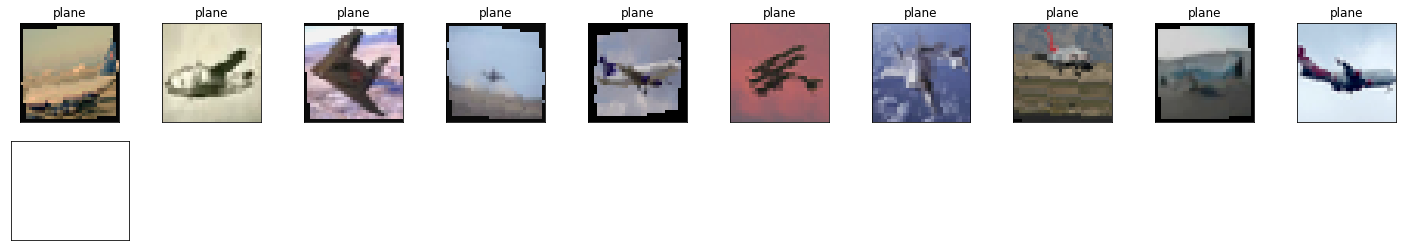

In [122]:
for images, labels in training_loader[0]:
  break
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [0]:
class CNN(nn.Module):
    def __init__(self, dataset):
        super(CNN, self).__init__()
        self.dataset = dataset

        if dataset == "cifar10" or dataset == "mnist":
            self.num_classes = 10

            if dataset == "cifar10":
                side_size = 32
                n_filters = 3
            else:
                n_filters = 1
                side_size = 28

            flatten_side_size = side_size - 2 * 3

            self.net = nn.Sequential(
                nn.Conv2d(n_filters, 32, (3, 3)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (3, 3)),
                nn.ReLU(),
                nn.Conv2d(64, 64, (3, 3)),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(64 * flatten_side_size * flatten_side_size, 64),
                nn.ReLU(),
                nn.Linear(64, self.num_classes)
            )

        elif dataset.startswith("digits"):
            if dataset == "digits":
                self.num_classes = 10
            else:
                self.num_classes = int(dataset[6:])
            self.net = nn.Sequential(
                nn.Conv2d(1, 8, (3, 3)),
                nn.ReLU(),
                nn.Conv2d(8, 16, (3, 3)),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(16 * 4 * 4, 32),
                nn.ReLU(),
                nn.Linear(32, self.num_classes)
            )

    def forward(self, x):
        return self.net(x)

In [0]:
class Tester():
  def __init__(self, training_loader, validation_loader, num_workers, restart_loss_history = True):
    self.num_workers = num_workers
    self.training_loader = training_loader
    self.validation_loader = validation_loader
    if restart_loss_history:
      self.val_running_loss_history = []
      self.val_running_corrects_history = []

  def setUpExperiment(self, model, device, criterion, max_num_rounds = 2000, num_local_steps = 1, sampling_rate = 1.0):
    self.max_num_rounds = max_num_rounds
    self.num_local_steps = num_local_steps
    self.device = device
    self.sampling_rate  = sampling_rate
    
    self.criterion = criterion
    self.model = model

    self.step_size = 0.001 / math.sqrt(self.num_local_steps)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.step_size)
    self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[1000,2000, 3000, 4000], gamma=0.5)

    
    self.delta = []
    self.sum_error = []
    self.avg_error = []
    param_list = list(self.model.parameters())
    for i in range(0, len(param_list)):
        self.delta.append(param_list[i]*0)
        self.sum_error.append(param_list[i]*0)
        self.avg_error.append(param_list[i]*0)

    self.num_rounds = 0

    while self.num_rounds <= self.max_num_rounds:
      self.runRound()
      self.num_rounds += 1
      self.scheduler.step(self.num_rounds)
      if self.num_rounds % 50 == 0:
        self.updateData()

  def computeJoinedGradient(self):
    inputs = []
    labels = []
    
    training_list = list(np.arange(0, num_workers))
    random.shuffle(training_list)
    training_list = training_list[0:math.ceil(sampling_rate * num_workers)]
    for worker in training_list:
      for batch_inputs, batch_labels in training_loader[worker]:
        inputs.append(batch_inputs)
        labels.append(batch_labels)
        break
    joined_inputs = torch.cat(inputs, 0).to(self.device)
    joined_labels = torch.cat(labels, 0).to(self.device)
 
    outputs = self.model(joined_inputs)
    loss = self.criterion(outputs, joined_labels)

    self.optimizer.zero_grad()
    loss.backward()


  def runRound(self):
    #update the error and sum before starting a new round
    for i, param in enumerate(model.parameters()):
      self.avg_error[i] = self.sum_error[i]/self.num_local_steps
      self.delta[i] = self.delta[i] + self.avg_error[i]
      self.sum_error[i] = self.sum_error[i] * 0

    for current_local_step in range(0, num_local_steps):
      self.computeJoinedGradient()
      for i, param in enumerate(model.parameters()):
        self.sum_error[i] += param.grad - self.delta[i]
        param.grad = self.delta[i] + self.avg_error[i]

      self.optimizer.step()
    
      
  def updateData(self):
    self.val_running_loss = 0.0
    self.val_running_corrects = 0.0
    with torch.no_grad():
      for val_inputs, val_labels in self.validation_loader:
        val_inputs = val_inputs.to(self.device)
        val_labels = val_labels.to(self.device)
        val_outputs = self.model(val_inputs)
        val_loss = self.criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        self.val_running_loss += val_loss.item()
        self.val_running_corrects += torch.sum(val_preds == val_labels.data)

    val_epoch_loss = self.val_running_loss/len(self.validation_loader)
    val_epoch_acc = self.val_running_corrects.float()/ len(self.validation_loader)
    self.val_running_loss_history.append(val_epoch_loss)
    self.val_running_corrects_history.append(val_epoch_acc)
    print('num_local_steps : ', self.num_local_steps, ', rounds communication : ', self.num_rounds)
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

In [0]:
#split the data
num_workers = 100
size = math.floor(len(full_data)/num_workers)
t_dataset_per_worker = []
for i in range(0, num_workers):
  t_dataset_per_worker.append(full_data[i*size:i*size+size])

In [0]:
#create the training loaders
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)
training_loader = [] 
worker_batch_size = 20
for i in range(0, num_workers):
  training_loader.append(torch.utils.data.DataLoader(t_dataset_per_worker[i], worker_batch_size, shuffle=True))


In [0]:
#Local steps before syncrhonization
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
tester = Tester(training_loader, validation_loader, num_workers)
model = LeNet().to(device)
        

In [239]:
list_local_steps = [2, 4, 6, 8, 10, 20]
for num_local_steps in list_local_steps:
  sampling_rate = 0.05
  print("num_local_steps ", num_local_steps, " num_workers ", num_workers, " batch_size per worker ", worker_batch_size, " sampling_rate ", sampling_rate)
  tester.setUpExperiment(model, device, criterion, 5000, num_local_steps, sampling_rate)
  #save data
  label ='bs:'+str(worker_batch_size)+', w:'+str(num_workers)+', s:'+str(sampling_rate)+', k:'+str(num_local_steps)
  history.append({'label':label, 'data':tester.val_running_loss_history})
  history_acc.append({'label':label, 'data':tester.val_running_corrects_history})

num_local_steps  1  num_workers  100  batch_size per worker  20  sampling_rate  0.05
num_local_steps :  1 , rounds communication :  50
validation loss: 2.2946, validation acc 12.4000 
num_local_steps :  1 , rounds communication :  100
validation loss: 2.1515, validation acc 20.8600 
num_local_steps :  1 , rounds communication :  150
validation loss: 2.0192, validation acc 22.6500 
num_local_steps :  1 , rounds communication :  200
validation loss: 1.9224, validation acc 29.6200 
num_local_steps :  1 , rounds communication :  250
validation loss: 1.8443, validation acc 31.0200 
num_local_steps :  1 , rounds communication :  300
validation loss: 1.8434, validation acc 31.1600 
num_local_steps :  1 , rounds communication :  350
validation loss: 1.7523, validation acc 34.4000 
num_local_steps :  1 , rounds communication :  400
validation loss: 1.7428, validation acc 34.7900 
num_local_steps :  1 , rounds communication :  450
validation loss: 1.7202, validation acc 36.6200 
num_local_steps 

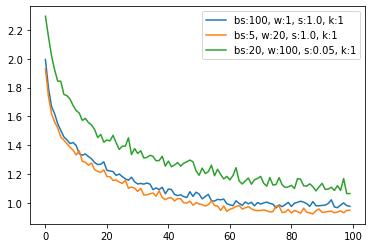

In [241]:
for experiment in history:
  plt.plot(experiment['data'], label=experiment['label'])
    
plt.legend()

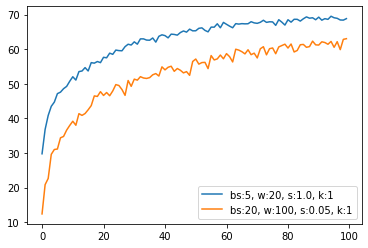

In [242]:
for experiment in history_acc:
  plt.plot(experiment['data'], label=experiment['label'])
    
plt.legend()

In [0]:
history = []
history_acc = []